# Introduction



This code is trying to build movie review sentiment classifier by converting review first into sentence embeddings using InferSent, which is developed by facebook. Then the embeddings will be passed into a feed forward nerual network for training. 

# 1 import section

In [ ]:
import torch

import pandas as pd
import matplotlib.pyplot as plt 

import torch
from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim



from tqdm import tqdm
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from collections import Counter
from sklearn.metrics import accuracy_score

from torch.optim import AdamW


In [ ]:
import nltk
nltk.download('punkt')

# 2 download Glove Embeddings, because InferSent is run on using Glove as word Embeddings first (Go to Section 5 if you already have the word embeddings generated beforehand)

run the follwing three command inside your terminal separately, it's gonna take some time, since its downloading 2G Glove

(1) mkdir GloVe

(2) curl -Lo GloVe/glove.840B.300d.zip http://nlp.stanford.edu/data/glove.840B.300d.zip

(3) unzip GloVe/glove.840B.300d.zip -d GloVe/

# 3 download InferSent and Load model

run the follwing two commands inside your terminal separately

mkdir encoder

curl -Lo encoder/infersent1.pkl https://dl.fbaipublicfiles.com/infersent/infersent1.pkl

In [ ]:
from models import InferSent
model_version = 1
MODEL_PATH = "encoder/infersent%s.pkl" % model_version
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': model_version}
model = InferSent(params_model)
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [ ]:
W2V_PATH = W2V_PATH = 'GloVe/glove.840B.300d.txt' if model_version == 1 else 'fastText/crawl-300d-2M.vec'
model.set_w2v_path(W2V_PATH)
model.build_vocab_k_words(K=100000)

Vocab size : 100000


In [ ]:
temp=model.encode(['the cat eats and the dog barks.'])
print(type(temp))
print(temp.shape)

<class 'numpy.ndarray'>
(1, 4096)


# 4 Generate Sentence Embeddings

method to save the fiels into google drive

In [ ]:
from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

auth.authenticate_user()

drive_service = build('drive', 'v3')

def save_file_to_drive(name, path):
    file_metadata = {'name': name,'mimeType': 'application/octet-stream'}
    media = MediaFileUpload(path, mimetype='application/octet-stream',resumable=True)

    created = drive_service.files().create(body=file_metadata,
                                   media_body=media,
                                   fields='id').execute()

    print('File ID: {}'.format(created.get('id')))

    return created


read in data, split them, generate embeddings, and then save to google drive, in case you lost it, so you don't need to generate embeddins every single time, you can load them into this colab

In [ ]:
df = pd.read_csv("movie_review_RT50K.csv")
X_train, X_test, Y_train, Y_test = train_test_split(df['content'], 
                                                    df['sentiment'], 
                                                    shuffle=True,
                                                    test_size=0.2, 
                                                    random_state=2021)

X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, 
                                                    Y_train, 
                                                    shuffle=True,
                                                    test_size=0.1, 
                                                    random_state=2021)
del df

method to get sentence embeddings from SentInfer

In [ ]:
def getSentEmbeddings(X):
  res=torch.tensor([])
  for i in tqdm(range(len(X))):
    temp=torch.tensor(model.encode([X.iloc[i]]))
    res=torch.cat((res,temp),dim=0)
  return res

get sentence embeddings for train, test and validation

In [ ]:

X_train_Em=getSentEmbeddings(X_train)
del X_train
torch.save(X_train_Em, 'X_train_Em.pt')
save_file_to_drive('X_train_Em', 'X_train_Em.pt')
del X_train_Em


X_test_Em=getSentEmbeddings(X_test)
del X_test
torch.save(X_test_Em, 'X_test_Em.pt')
save_file_to_drive('X_test_Em', 'X_test_Em.pt')
del X_test_Em

X_valid_Em=getSentEmbeddings(X_valid)
del X_valid
torch.save(X_valid_Em, 'X_valid_Em.pt')
save_file_to_drive('X_valid_Em', 'X_valid_Em.pt')

  0%|          | 0/10000 [00:00<?, ?it/s]

File ID: 1cs7b3670ddowtkjyLFxDsiSvh5ujnX1x


  0%|          | 1/4000 [00:00<08:42,  7.66it/s]

File ID: 16YGd_KY1PaXEhOuKcEVeAC1Mtl5m67Q3


100%|██████████| 4000/4000 [12:28<00:00,  5.35it/s]


File ID: 1M8dHnBLPUbzdVbKbyqbOODC6Hj-XDXRv


{'id': '1M8dHnBLPUbzdVbKbyqbOODC6Hj-XDXRv'}

# 5 load pre-generated sentence embeddings from drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
X_train_Em=torch.load('drive/MyDrive/colab Data/NLPFinal/50k sen/X_train_Em.pt')
X_test_Em=torch.load('drive/MyDrive/colab Data/NLPFinal/50k sen/X_test_Em.pt')
X_valid_Em=torch.load('drive/MyDrive/colab Data/NLPFinal/50k sen/X_valid_Em.pt')
print(X_train_Em.shape)
print(X_test_Em.shape)
print(X_valid_Em.shape)

torch.Size([36000, 4096])
torch.Size([10000, 4096])
torch.Size([4000, 4096])


# 6 Load the orginial targets

**radom state make sure data y is the same as the original data**

In [ ]:
df = pd.read_csv("movie_review_RT50K.csv")
X_train, X_test, Y_train, Y_test = train_test_split(df['content'], 
                                                    df['sentiment'], 
                                                    shuffle=True,
                                                    test_size=0.2, 
                                                    random_state=2021)

X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, 
                                                    Y_train, 
                                                    shuffle=True,
                                                    test_size=0.1, 
                                                    random_state=2021)
del X_train
del X_valid
del X_test
del df

In [ ]:
train_y = torch.tensor(Y_train.tolist())
val_y = torch.tensor(Y_valid.tolist())
test_y = torch.tensor(Y_test.tolist())
print(train_y.shape)
print(val_y.shape)
print(test_y.shape)

torch.Size([36000])
torch.Size([4000])
torch.Size([10000])


# 7 define classifier

In [ ]:
class sentANN(nn.Module):

    def __init__(self):
      
      super(sentANN, self).__init__()
    
      self.dropout = nn.Dropout(0.1)     
      self.relu =  nn.ReLU()
      #universal sentence embeddings are of size 4096 per sentence
      self.fc1 = nn.Linear(4096,512)  
      # self.fc2= nn.Linear(4096,512)
      # self.fc3= nn.Linear(1024,512)
      self.fcE = nn.Linear(512,2)    
      self.softmax = nn.LogSoftmax(dim=1)


    def forward(self, x):
          
      x= self.dropout(self.relu(self.fc1(x)))
      # x= self.dropout(self.relu(self.fc2(x)))
      # x= self.dropout(self.relu(self.fc3(x)))
      x = self.fcE(x)
      x = self.softmax(x)

      return x

tempS=X_test_Em[0].view(-1,4096)
model=sentANN()
model(tempS)


tensor([[-0.7116, -0.6750]], grad_fn=<LogSoftmaxBackward>)

# 8 Training 20 epochs

In [ ]:
device = torch.device("cuda")

In [ ]:
trainLen=len(X_train_Em)
testLen=len(X_test_Em)
validLen=len(X_valid_Em)
print(trainLen,testLen,validLen)

36000 10000 4000


define a validaiton method

In [ ]:
# val_seq val_mask val_y
def getValid():
  
  model.eval()
  with torch.no_grad():
    
    BATCH_SIZE=100
    temp_pred=[]
    validLoss=0

    for i in range(0,validLen,BATCH_SIZE):

      endIndex=min(i+BATCH_SIZE,validLen)
      x=X_valid_Em[i:endIndex].to(device)        
      labels=val_y[i:endIndex].to(device) 

      output=model(x)    

      predicted_class=torch.argmax(output,dim=-1).cpu().tolist()        
      temp_pred.extend(predicted_class) 

      loss = loss_function(output, labels)
      validLoss += loss.item()


    validLoss=round(validLoss /validLen,5)
    validAcc=round(accuracy_score(val_y.tolist(), temp_pred),3)

  return validLoss,validAcc

actual training

In [ ]:
%%time
BATCH_SIZE=100

model=sentANN()
model.to(device)

optimizer = AdamW(model.parameters(),lr = 1e-4)   
loss_function=nn.CrossEntropyLoss()
num_epochs=10


train_loss=[]
val_loss=[]
val_acc=[]

model.train()   #to speicify the training condition

for epoch in range(num_epochs):
    print("Epoch" + str(epoch + 1),'finished')
    trainLoss = 0

    for i in tqdm(range(0,trainLen,BATCH_SIZE)):

        model.zero_grad()
        
        endIndex=min(i+BATCH_SIZE,trainLen)

        x=X_train_Em[i:endIndex].to(device)        
        labels=train_y[i:endIndex].to(device)      

        output = model(x)
        loss = loss_function(output, labels)
        trainLoss = trainLoss + loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()                
    
    trainLoss=round(trainLoss / trainLen,5)      
    validLoss,validAcc=getValid()

    train_loss.append(trainLoss)
    val_loss.append(validLoss)
    val_acc.append(validAcc)

    model.train()   

    print()
    print(trainLoss)


 13%|█▎        | 48/360 [00:00<00:00, 479.19it/s]

Epoch1 finished


 13%|█▎        | 48/360 [00:00<00:00, 473.94it/s]


0.0054
Epoch2 finished


 14%|█▍        | 50/360 [00:00<00:00, 493.24it/s]


0.00482
Epoch3 finished


 13%|█▎        | 48/360 [00:00<00:00, 479.14it/s]


0.00464
Epoch4 finished


 14%|█▍        | 50/360 [00:00<00:00, 494.88it/s]


0.00452
Epoch5 finished


 14%|█▍        | 50/360 [00:00<00:00, 492.02it/s]


0.00443
Epoch6 finished


 14%|█▎        | 49/360 [00:00<00:00, 484.24it/s]


0.00434
Epoch7 finished


 14%|█▍        | 50/360 [00:00<00:00, 493.99it/s]


0.00427
Epoch8 finished


 14%|█▍        | 50/360 [00:00<00:00, 497.68it/s]


0.00421
Epoch9 finished


 14%|█▍        | 50/360 [00:00<00:00, 498.00it/s]


0.00414
Epoch10 finished


100%|██████████| 360/360 [00:00<00:00, 489.70it/s]


0.00409
CPU times: user 7.81 s, sys: 204 ms, total: 8.01 s
Wall time: 7.86 s


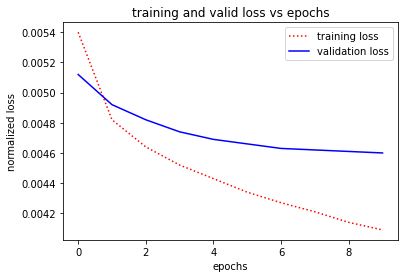

In [ ]:
epoch_list=[i for i in range(0,10)]
plt.plot( epoch_list,train_loss, label="training loss",linestyle='dotted',color='red')
plt.plot( epoch_list,val_loss, label="validation loss",color='blue')

plt.xlabel("epochs")
plt.ylabel("normalized loss")
plt.legend(loc="best")
plt.title('training and valid loss vs epochs')
plt.show()


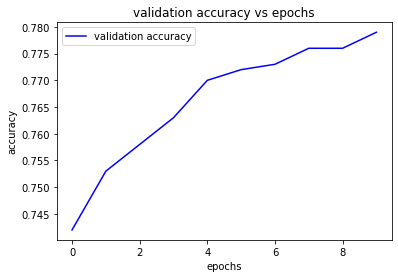

In [ ]:
epoch_list=[i for i in range(0,10)]
plt.plot( epoch_list,val_acc, label="validation accuracy",color='blue')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(loc="best")
plt.title('validation accuracy vs epochs')
plt.show()


In [ ]:
BATCH_SIZE=100
y_pred = []
model.eval()

with torch.no_grad():
     for i in tqdm(range(0,testLen,BATCH_SIZE)):
        endIndex=min(i+BATCH_SIZE,testLen)

        x=X_test_Em[i:endIndex].to(device)            
        output = model(x)

        predicted_class=torch.argmax(output,dim=-1).cpu().tolist()        
        y_pred.extend(predicted_class)      

print()
print(classification_report(Y_test.tolist(),y_pred))

100%|██████████| 100/100 [00:00<00:00, 1443.28it/s]


              precision    recall  f1-score   support

           0       0.77      0.82      0.79      5028
           1       0.81      0.75      0.78      4972

    accuracy                           0.79     10000
   macro avg       0.79      0.79      0.79     10000
weighted avg       0.79      0.79      0.79     10000



# 9 Training 50 epochs

In [ ]:
%%time
BATCH_SIZE=100

model=sentANN()
model.to(device)

optimizer = AdamW(model.parameters(),lr = 1e-4)   
loss_function=nn.CrossEntropyLoss()
num_epochs=50


train_loss=[]
val_loss=[]
val_acc=[]

model.train()   #to speicify the training condition

for epoch in range(num_epochs):
    print("Epoch" + str(epoch + 1),'finished')
    trainLoss = 0

    for i in tqdm(range(0,trainLen,BATCH_SIZE)):

        model.zero_grad()
        
        endIndex=min(i+BATCH_SIZE,trainLen)

        x=X_train_Em[i:endIndex].to(device)        
        labels=train_y[i:endIndex].to(device)      

        output = model(x)
        loss = loss_function(output, labels)
        trainLoss = trainLoss + loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()                
    
    trainLoss=round(trainLoss / trainLen,5)      
    validLoss,validAcc=getValid()

    train_loss.append(trainLoss)
    val_loss.append(validLoss)
    val_acc.append(validAcc)

    model.train()   

    print()
    print(trainLoss)


 14%|█▍        | 50/360 [00:00<00:00, 497.23it/s]

Epoch1 finished


 14%|█▎        | 49/360 [00:00<00:00, 488.25it/s]


0.0054
Epoch2 finished


 13%|█▎        | 48/360 [00:00<00:00, 479.75it/s]


0.00482
Epoch3 finished


 14%|█▍        | 51/360 [00:00<00:00, 503.65it/s]


0.00464
Epoch4 finished


 14%|█▎        | 49/360 [00:00<00:00, 489.47it/s]


0.00452
Epoch5 finished


 14%|█▎        | 49/360 [00:00<00:00, 483.57it/s]


0.00443
Epoch6 finished


 14%|█▎        | 49/360 [00:00<00:00, 488.16it/s]


0.00435
Epoch7 finished


 14%|█▎        | 49/360 [00:00<00:00, 488.81it/s]


0.00428
Epoch8 finished


 13%|█▎        | 48/360 [00:00<00:00, 471.29it/s]


0.00422
Epoch9 finished


 14%|█▎        | 49/360 [00:00<00:00, 484.90it/s]


0.00415
Epoch10 finished


 13%|█▎        | 47/360 [00:00<00:00, 466.57it/s]


0.0041
Epoch11 finished


 14%|█▎        | 49/360 [00:00<00:00, 483.49it/s]


0.00405
Epoch12 finished


 14%|█▎        | 49/360 [00:00<00:00, 482.73it/s]


0.004
Epoch13 finished


 14%|█▍        | 50/360 [00:00<00:00, 494.12it/s]


0.00395
Epoch14 finished


 14%|█▎        | 49/360 [00:00<00:00, 480.83it/s]


0.0039
Epoch15 finished


 13%|█▎        | 48/360 [00:00<00:00, 475.80it/s]


0.00386
Epoch16 finished


 14%|█▎        | 49/360 [00:00<00:00, 488.35it/s]


0.00381
Epoch17 finished


 13%|█▎        | 47/360 [00:00<00:00, 466.78it/s]


0.00377
Epoch18 finished


 14%|█▎        | 49/360 [00:00<00:00, 481.34it/s]


0.00372
Epoch19 finished


 13%|█▎        | 48/360 [00:00<00:00, 470.85it/s]


0.00368
Epoch20 finished


 14%|█▎        | 49/360 [00:00<00:00, 481.66it/s]


0.00364
Epoch21 finished


 14%|█▍        | 50/360 [00:00<00:00, 494.64it/s]


0.0036
Epoch22 finished


 13%|█▎        | 47/360 [00:00<00:00, 460.91it/s]


0.00355
Epoch23 finished


 13%|█▎        | 48/360 [00:00<00:00, 474.11it/s]


0.00351
Epoch24 finished


 14%|█▍        | 50/360 [00:00<00:00, 495.52it/s]


0.00346
Epoch25 finished


 14%|█▎        | 49/360 [00:00<00:00, 487.68it/s]


0.00342
Epoch26 finished


 14%|█▍        | 50/360 [00:00<00:00, 492.21it/s]


0.00337
Epoch27 finished


 14%|█▎        | 49/360 [00:00<00:00, 487.79it/s]


0.00332
Epoch28 finished


 14%|█▎        | 49/360 [00:00<00:00, 489.10it/s]


0.00326
Epoch29 finished


 14%|█▍        | 50/360 [00:00<00:00, 491.03it/s]


0.00322
Epoch30 finished


 14%|█▎        | 49/360 [00:00<00:00, 483.53it/s]


0.00317
Epoch31 finished


 13%|█▎        | 47/360 [00:00<00:00, 467.31it/s]


0.00311
Epoch32 finished


 14%|█▍        | 50/360 [00:00<00:00, 491.82it/s]


0.00307
Epoch33 finished


 14%|█▍        | 50/360 [00:00<00:00, 499.57it/s]


0.00301
Epoch34 finished


 14%|█▎        | 49/360 [00:00<00:00, 487.07it/s]


0.00295
Epoch35 finished


 14%|█▎        | 49/360 [00:00<00:00, 486.05it/s]


0.00289
Epoch36 finished


 13%|█▎        | 48/360 [00:00<00:00, 475.93it/s]


0.00283
Epoch37 finished


 14%|█▎        | 49/360 [00:00<00:00, 485.49it/s]


0.00278
Epoch38 finished


 14%|█▎        | 49/360 [00:00<00:00, 488.40it/s]


0.00272
Epoch39 finished


 13%|█▎        | 48/360 [00:00<00:00, 474.36it/s]


0.00266
Epoch40 finished


 14%|█▎        | 49/360 [00:00<00:00, 482.99it/s]


0.0026
Epoch41 finished


 14%|█▎        | 49/360 [00:00<00:00, 484.97it/s]


0.00254
Epoch42 finished


 14%|█▍        | 50/360 [00:00<00:00, 494.28it/s]


0.00248
Epoch43 finished


 14%|█▎        | 49/360 [00:00<00:00, 487.12it/s]


0.00242
Epoch44 finished


 13%|█▎        | 48/360 [00:00<00:00, 477.38it/s]


0.00235
Epoch45 finished


 13%|█▎        | 48/360 [00:00<00:00, 475.17it/s]


0.0023
Epoch46 finished


 14%|█▎        | 49/360 [00:00<00:00, 486.82it/s]


0.00223
Epoch47 finished


 13%|█▎        | 48/360 [00:00<00:00, 479.14it/s]


0.00217
Epoch48 finished


 13%|█▎        | 48/360 [00:00<00:00, 476.98it/s]


0.0021
Epoch49 finished


 13%|█▎        | 48/360 [00:00<00:00, 475.15it/s]


0.00203
Epoch50 finished


100%|██████████| 360/360 [00:00<00:00, 477.00it/s]


0.00197
CPU times: user 39.2 s, sys: 1.07 s, total: 40.3 s
Wall time: 39.5 s


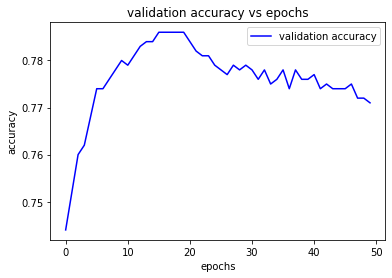

In [ ]:
epoch_list=[i for i in range(0,50)]
plt.plot( epoch_list,val_acc, label="validation accuracy",color='blue')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(loc="best")
plt.title('validation accuracy vs epochs')
plt.show()


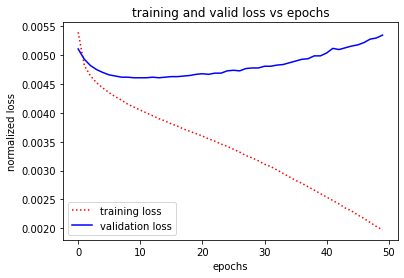

In [ ]:
epoch_list=[i for i in range(0,50)]
plt.plot( epoch_list,train_loss, label="training loss",linestyle='dotted',color='red')
plt.plot( epoch_list,val_loss, label="validation loss",color='blue')

plt.xlabel("epochs")
plt.ylabel("normalized loss")
plt.legend(loc="best")
plt.title('training and valid loss vs epochs')
plt.show()


In [ ]:
BATCH_SIZE=100
y_pred = []
model.eval()

with torch.no_grad():
     for i in tqdm(range(0,testLen,BATCH_SIZE)):
        endIndex=min(i+BATCH_SIZE,testLen)

        x=X_test_Em[i:endIndex].to(device)            
        output = model(x)

        predicted_class=torch.argmax(output,dim=-1).cpu().tolist()        
        y_pred.extend(predicted_class)      

print()
print(classification_report(Y_test.tolist(),y_pred))

100%|██████████| 100/100 [00:00<00:00, 1332.00it/s]


              precision    recall  f1-score   support

           0       0.76      0.82      0.79      5028
           1       0.80      0.74      0.77      4972

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000

